HOW LIVERPOOL AND MANCHESTER CITY ATTACK USING xG AND xA DATA

INTRODUCTION

The title race in the Premier League this season has been a story of two teams clearly leading the rest of the pack. Manchester City and Liverpool have dominated the league and we will most likely see the title go to one of them at the end of the season, as has happended in the last previous years. Not only have they been the best teams in the league overall, they are also clearly a cut above other teams when it comes to attack. 

To analyze how both teams construct their attacks, we can use data provided by fbref.com pertaining to shots and shot-creation such as 'xG' and 'xA'. 'xG' stands for 'Expected Goals' and it aims to evaluate the quality of shots by estimating the probability of this type of shot resulting in a goal. The metric takes into account various variables such as location on the pitch, type of pass preceding the shot or the body part with which the shot was taken. Closely related is 'xA' (Expected Assists), which describes the xG of a shot that resulted from a given pass.

As football is a high-variance sport, metrics such as 'xG' and 'xA' are often used to describe performance of a team/player without relying solely on the more variable goals and assists. For instance, it can be used to evaluate how good at attack a certain team is, or how good a given player is at finding good chances(taking shots with high likelihood of ending up in goal) or providing their colleages with such chances. 

In this analysis, I use 'xG' and 'xA' data to see what players in Manchester City and Liverpool are primary goal scorers(high 'xG') and chance providers (high 'xA'), as well as, what it tells us about the teams' approaches to creating scoring opportunities.


It is worth noting that the table contains per/90 data, which means that it is averaged over the number of minutes a team or player has played, rather than the total sum over amassed over the course of the season.

Let's start by downloading all the necessary libraries as well as looking at the tables from fbref.com that have already been put in a SQL database. 

*note - 'npxG' is shorthand for 'Non-penalty Expected Goals' and is often used as penalties can artificially inflate players' xG numbers while not necesserily reflecting their ability to find great chances. Similarily, the number of penalties a team receives in a given season is highly variable, thus, npxG might be used to account for that. 

In [14]:
#Downloading the libraries used


%load_ext sql

from sqlalchemy import create_engine
import psycopg2


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

The sql extension is already loaded. To reload it, use:
  %reload_ext sql


In [15]:
%sql postgresql://localhost/premier_league_stats
engine = create_engine('postgresql://localhost/premier_league_stats')

Looking at how the data is formatted.

In [16]:
%%sql
SELECT table_name, column_name, data_type FROM information_schema.columns 
WHERE table_name IN ('standard_stats_teams', 'standard_stats_teams_prev_season', 'standard_stats_players')
ORDER BY table_name, column_name;

 * postgresql://localhost/premier_league_stats
34 rows affected.


table_name,column_name,data_type
standard_stats_players,90s,real
standard_stats_players,ast,real
standard_stats_players,born,integer
standard_stats_players,gls,real
standard_stats_players,gls_penalties,real
standard_stats_players,min,integer
standard_stats_players,nation,character varying
standard_stats_players,npxG,real
standard_stats_players,player,character varying
standard_stats_players,position,character varying


We can see that the numerical values are stored as a real data type, which might cause issues while making different operations. Thus, if need be, it might be necessary to cast it as a different data type to perform some operations. 

Now, let's look at team data for both this and previous season.

In [4]:
%%sql
SELECT * FROM standard_stats_teams
UNION ALL 
SELECT * FROM standard_stats_teams_prev_season
ORDER BY squad;

 * postgresql://localhost/premier_league_stats
40 rows affected.


squad,average_age,possession,90s,gls,ast,gls_penalties,npxG,xA,xG_penalties
Arsenal,25.2,51.8,28,1.46,1.11,0.08,1.41,1.0,0.13
Arsenal,25.9,53.8,38,1.24,1.0,0.15,1.29,0.96,0.12
Aston Villa,26.7,46.2,29,1.28,1.14,0.06,1.08,0.88,0.04
Aston Villa,25.2,48.1,38,1.24,1.0,0.13,1.28,0.98,0.11
Brentford,26.1,44.2,30,0.87,0.67,0.2,1.03,0.75,0.15
Brighton,26.9,57.0,29,0.76,0.72,0.1,0.96,0.72,0.11
Brighton,25.8,51.3,38,0.87,0.63,0.16,1.18,0.87,0.18
Burnley,28.3,41.7,38,0.76,0.53,0.08,0.99,0.71,0.06
Burnley,29.4,38.9,27,0.74,0.63,0.0,0.89,0.65,0.0
Chelsea,27.9,60.1,28,1.75,1.43,0.25,1.49,1.2,0.18


We can see that the tables contain the right number of teams (17 repeating + 6 relegated/promoted) and there do not appear any issues with the formatting. 

And now let's see the player table.

In [28]:
%%sql

SELECT * FROM standard_stats_players LIMIT 10;

 * postgresql://localhost/premier_league_stats
10 rows affected.


rank,player,nation,position,squad,born,min,90s,gls,ast,gls_penalties,npxG,xA,xG_penalties,player_id,player_name
1,Max Aarons\774cf58b,eng ENG,DF,Norwich City,2000,2398,26.6,0.0,0.04,0.0,0.02,0.04,0.0,774cf58b,Max Aarons
2,Che Adams\f2bf1b0f,sct SCO,FW,Southampton,1996,1647,18.3,0.38,0.16,0.0,0.3,0.12,0.0,f2bf1b0f,Che Adams
3,Rayan Aït Nouri\9b398aea,fr FRA,DF,Wolves,2001,1373,15.3,0.0,0.13,0.0,0.03,0.08,0.0,9b398aea,Rayan Aït Nouri
4,Kristoffer Ajer\a8c0acb7,no NOR,DF,Brentford,1998,1405,15.6,0.0,0.13,0.0,0.01,0.06,0.0,a8c0acb7,Kristoffer Ajer
5,Nathan Aké\eaeca114,nl NED,DF,Manchester City,1995,671,7.5,0.13,0.0,0.0,0.1,0.07,0.0,eaeca114,Nathan Aké
6,Marc Albrighton\b827d5b3,eng ENG,FWDF,Leicester City,1989,997,11.1,0.09,0.09,0.0,0.05,0.11,0.0,b827d5b3,Marc Albrighton
7,Thiago Alcántara\77e84962,es ESP,MF,Liverpool,1991,1009,11.2,0.09,0.18,0.0,0.14,0.14,0.0,77e84962,Thiago Alcántara
8,Trent Alexander-Arnold\cd1acf9d,eng ENG,DF,Liverpool,1998,2313,25.7,0.08,0.43,0.0,0.09,0.37,0.0,cd1acf9d,Trent Alexander-Arnold
9,Alisson\7a2e46a8,br BRA,GK,Liverpool,1992,2430,27.0,0.0,0.04,0.0,0.0,0.02,0.0,7a2e46a8,Alisson
10,Allan\cc700722,br BRA,MF,Everton,1991,1934,21.5,0.0,0.09,0.0,0.01,0.04,0.0,cc700722,Allan


The player column contains both the player's name and their id code. The data will be more legible if separated into two columns. Additionally we can see that the players' nationalites are written in two formats, however, as they are not used for the purpose of this analysis, it's not necessary to correct them. Finally, it is worth noting that for players who play more than one position, the positions are listed in one column without separation(for instance 'MFFW' means that a player played as a midfielder and a forward this season).

Let's now correct the player column by separating name and id code into separate columns.

In [27]:
%%sql

ALTER TABLE standard_stats_players
ADD COLUMN player_id VARCHAR(8),
ADD COLUMN player_name VARCHAR(50);


UPDATE standard_stats_players
SET player_id = split_part(player, '\', 2),
    player_name = split_part(player, '\', 1);

 * postgresql://localhost/premier_league_stats
Done.
529 rows affected.


[]

We can now move on to analysing the data. Let's start by considering what teams have performed best when it comes to creating chances by looking at the npxG stats.

In [29]:
%%sql

SELECT squad, "npxG" FROM standard_stats_teams
ORDER BY "npxG" DESC;

 * postgresql://localhost/premier_league_stats
20 rows affected.


squad,npxG
Liverpool,2.31
Manchester City,2.12
Tottenham,1.6
Chelsea,1.49
Manchester Utd,1.47
Arsenal,1.41
Leicester City,1.34
Southampton,1.28
West Ham,1.24
Leeds United,1.21


We can see that Liverpool and Manchester City are clearly the best teams in the league in terms of attack. Let's see how it changed from the previous season.

In [30]:
%%sql

SELECT c.squad, c."npxG", p."npxG" AS prev_season_npxG, (c."npxG" - p."npxG") AS npxG_change FROM standard_stats_teams AS c
INNER JOIN standard_stats_teams_prev_season AS p
ON c.squad = p.squad
ORDER BY p."npxG" DESC;

 * postgresql://localhost/premier_league_stats
17 rows affected.


squad,npxG,prev_season_npxg,npxg_change
Liverpool,2.31,1.79,0.52
Manchester City,2.12,1.75,0.3699999
Chelsea,1.49,1.48,0.00999999
Leeds United,1.21,1.43,-0.21999991
Manchester Utd,1.47,1.37,0.100000024
Tottenham,1.6,1.33,0.26999998
West Ham,1.24,1.33,-0.09000003
Arsenal,1.41,1.29,0.120000005
Aston Villa,1.08,1.28,-0.19999993
Leicester City,1.34,1.23,0.110000014


We can see that, although the two leading teams were still leading the table, however they were not as dominant as this season. Remarkably, despite already being the best attaking outfit in the league, Liverpool managed to add 0.5 npxG per game this season.

Let's make the table a bit more legible by plotting it using a seaborn heatmap.

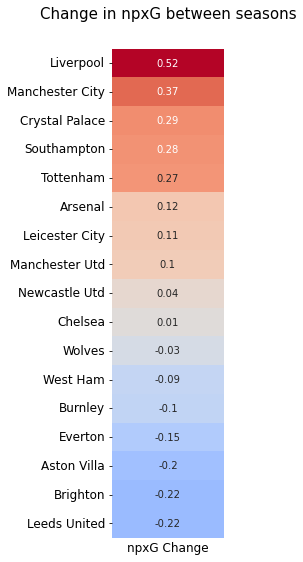

In [33]:
change_xg_command = '''
SELECT c.squad, ROUND(CAST((c."npxG" - p."npxG") AS numeric), 2) AS npxG_change FROM standard_stats_teams AS c
INNER JOIN standard_stats_teams_prev_season AS p
ON c.squad = p.squad
ORDER BY npxG_change  DESC;
'''

change_xg = pd.read_sql(change_xg_command, engine, index_col = 'squad')


fig, ax = plt.subplots(1,1, figsize=(2,9))
sns.heatmap(change_xg, annot = True, cmap = 'coolwarm', center = 0, cbar = False, xticklabels=False)

ax.set_title('Change in npxG between seasons', pad=30,fontdict={"fontsize":15})
plt.xlabel('npxG Change', fontdict={"fontsize":12})
plt.ylabel('')
ax.tick_params(axis="y", labelsize=12 )


We can now more clearly see the distance in improvement between the leading two teams and the rest of the league. None of the other teams were able to exceed the 0.3 npxg added threshold. Moreover, we can see that teams that were behind Liverpool and Man City in npxG generated last season have not improved much (Chelsea) or outright declined (Leeds). 


Let's now look a bit more closely at who at Liverpool plays the role of primary goalscorers (high npxG) and creators (high xA). 

First let's create a view containing sums to be easily accessible later, to be able to see who in a given team has contributed the most in attack.

In [37]:
%%sql

CREATE VIEW standard_stats_players_total AS (
    SELECT squad, player_name, position, CAST("npxG" * "90s" AS numeric)  AS total_npxg, CAST("xA" * "90s" AS numeric) AS total_xa
    FROM standard_stats_players
);

 * postgresql://localhost/premier_league_stats
Done.


[]

Then, using window functions to show player's contributions to the team's chances.

In [38]:
%%sql

SELECT 
    squad,
    player_name,
    position,
    total_npxg, 
    ROUND(100 * total_npxg/SUM(total_npxg) OVER(PARTITION BY squad), 2) AS npxg_percentage
FROM standard_stats_players_total
WHERE squad = 'Liverpool'
ORDER BY npxg_percentage DESC;


 * postgresql://localhost/premier_league_stats
27 rows affected.


squad,player_name,position,total_npxg,npxg_percentage
Liverpool,Sadio Mané,FW,14.326,21.04
Liverpool,Mohamed Salah,FW,14.056,20.64
Liverpool,Diogo Jota,FW,12.998,19.09
Liverpool,Roberto Firmino,FW,4.664,6.85
Liverpool,Trent Alexander-Arnold,DF,2.313,3.40
Liverpool,Luis Díaz,FW,2.31,3.39
Liverpool,Virgil van Dijk,DF,2.16,3.17
Liverpool,Joël Matip,DF,1.84,2.70
Liverpool,Fabinho,MF,1.672,2.46
Liverpool,Thiago Alcántara,MF,1.568,2.30


We can clearly see that goalscoring is mainly delegated to the forwards, with the three starting ones (Mané, Salah and Jota) and one substitute (Firmino) responsible for around two-thirds of the team's npxG. It is also notable that the midfielders do not seem to be responsible for getting into shooting opportunities, as they have fewer npxG than even three of the four starting defenders. 

To see how good  the attacking output of Liverpool's forwards is, let's compare them with the rest of the league by looking at the best players in the league in terms of npxG/90, . 

In [39]:
top_npxG_command = '''

SELECT
    squad,
    player_name,
    "npxG"
FROM standard_stats_players

-- picking only players that have played at least ten-games' worth of minutes

WHERE "90s" >= 10
ORDER BY "npxG" DESC
LIMIT 10;
'''

top_npxG = pd.read_sql(top_npxG_command, engine)

Text(0, 0.5, '')

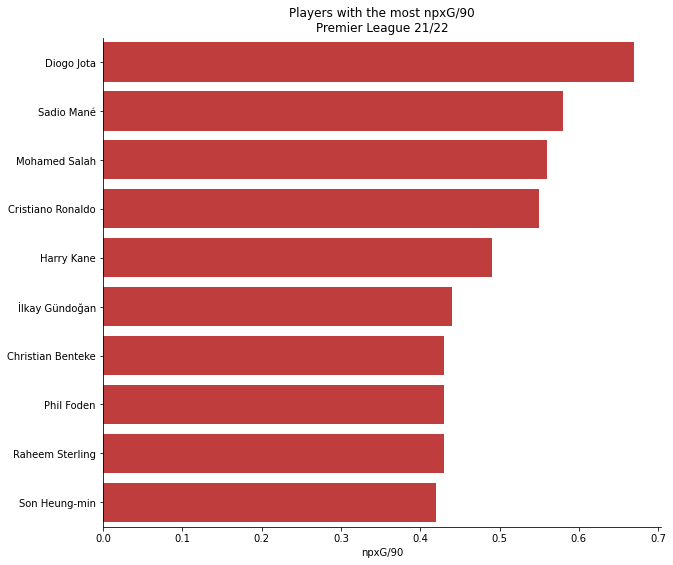

In [41]:
fig, ax = plt.subplots(figsize = (10,9))

sns.barplot(x = top_npxG.npxG, y = top_npxG.player_name, color = "tab:red")
sns.despine()
plt.title('Players with the most npxG/90\nPremier League 21/22')
plt.xlabel('npxG/90')
plt.ylabel('')


Remarkably, all three of Liverpool's starting forwards are leading the league in npxG/90 and are three of the four players able to exceed 0.5 npxG/90. 

Let's now look at Liverpool's shot creation by doing a similar table for expected assists.

In [42]:
%%sql

-- Reusing the same code, this time for expected assists

SELECT 
    player_name,
    position,
    total_xa, 
     ROUND(100 * total_xa/SUM(total_xa) OVER(PARTITION BY squad), 2) AS xa_percentage
FROM standard_stats_players_total
WHERE squad = 'Liverpool'
ORDER BY total_xa DESC;

 * postgresql://localhost/premier_league_stats
27 rows affected.


player_name,position,total_xa,xa_percentage
Trent Alexander-Arnold,DF,9.509,19.76
Mohamed Salah,FW,8.534,17.73
Andrew Robertson,DF,4.945,10.28
Diogo Jota,FW,4.074,8.47
Sadio Mané,FW,3.705,7.70
Jordan Henderson,MF,3.345,6.95
Roberto Firmino,FW,1.936,4.02
Kostas Tsimikas,DF,1.702,3.54
Thiago Alcántara,MF,1.568,3.26
James Milner,MFDF,1.42,2.95


The most remarkable aspect of Liverpool's attack appears to be the role that the fullbacks (Trent Alexander-Arnold and Andrew Robertson) play in chance creation. Together, they combine for 30% of Liverpool's xA. Again, the more reserved role of the midfielders is also noticeable, with only one (Jordan Henderson) contributing more than 5% of the total xA. 

(Also interesting is that goalkeeper Alisson has managed to amass almost half an expected assist, quite a remarkable feat given the distance from one goal to the other.)

To better appreciate how much the fullbacks contribute in attack, let's look at the npxG and xA data of all players in the league who have played at least ten games' worth of minutes(to avoid outliers due to small sample size).
 

In [43]:
#Creating a dataframe of players who have played more than 900 minutes (10 games' worth) to avoid outliers

player_attack_contribution_command = '''
SELECT squad, player_name, position, "npxG", "xA"
FROM standard_stats_players
WHERE "90s" >= 10;
'''
player_attack_contribution = pd.read_sql(player_attack_contribution_command, engine)

Text(214    0.03
Name: npxG, dtype: float64, 214    0.24
Name: xA, dtype: float64, 'Andrew Robertson')

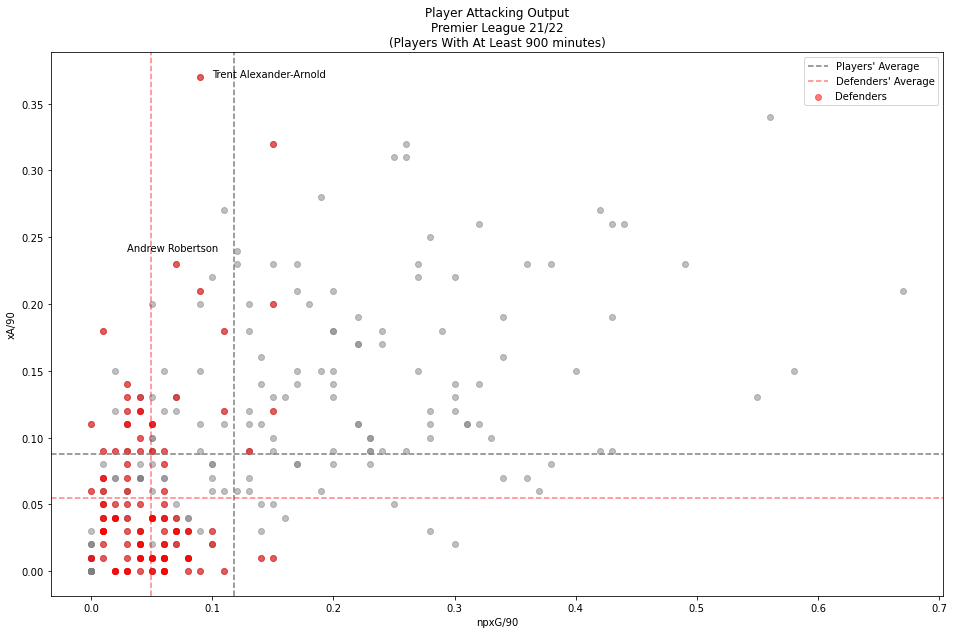

In [45]:
#Plotting npxG and xA contributions for all players in the league (who played >= 900 minutes)
#with defenders highlighted in red.

fig, ax = plt.subplots(1,1, figsize = (16,10))

ax.scatter(player_attack_contribution.npxG, player_attack_contribution.xA, alpha = 0.5, c = 'gray')

ax.set_title('Player Attacking Output\nPremier League 21/22\n(Players With At Least 900 minutes)')
ax.set_xlabel('npxG/90')
ax.set_ylabel('xA/90')

#Marking the average player's npxG and xA
ax.axvline(player_attack_contribution.npxG.mean(), c = 'gray', ls = '--', label = "Players' Average")
ax.axhline(player_attack_contribution.xA.mean(), c = 'gray', ls = '--')


#Creating a table with only defenders and plotting it on the graph in a different color
defender_attack_contribution = player_attack_contribution[player_attack_contribution.position.str.contains('DF')==True]

ax.scatter(defender_attack_contribution.npxG, defender_attack_contribution.xA, alpha = 0.5, c = 'red', label = 'Defenders')

#Marking the average defender's npxG and xA
ax.axvline(defender_attack_contribution.npxG.mean(), c = 'red', ls = '--', alpha = 0.5, label = "Defenders' Average")
ax.axhline(defender_attack_contribution.xA.mean(), c = 'red', ls = '--', alpha = 0.5)

ax.legend(loc = 'best')

#Showing the location of Liverpool's fullbacks

ax.annotate(
    'Trent Alexander-Arnold',
    xy = (player_attack_contribution[player_attack_contribution.player_name.str.contains('Trent Alexander-Arnold')].npxG,
          player_attack_contribution[player_attack_contribution.player_name.str.contains('Trent Alexander-Arnold')].xA),
    xytext = (0.01 + player_attack_contribution[player_attack_contribution.player_name.str.contains('Trent Alexander-Arnold')].npxG,
          player_attack_contribution[player_attack_contribution.player_name.str.contains('Trent Alexander-Arnold')].xA))


ax.annotate(
    'Andrew Robertson',
    xy = (player_attack_contribution[player_attack_contribution.player_name.str.contains("Andrew Robertson")].npxG,
        player_attack_contribution[player_attack_contribution.player_name.str.contains("Andrew Robertson")].xA),
    xytext = (-0.04 + player_attack_contribution[player_attack_contribution.player_name.str.contains("Andrew Robertson")].npxG,
             0.01 + player_attack_contribution[player_attack_contribution.player_name.str.contains("Andrew Robertson")].xA))



We can see that Alexander-Arnold is leading the xA/90 stats in the league, at the level where only one defender is somewhat close. Moreover, Andrew Robertson is also near the top of the creators among defenders. 



Now, let's look at Liverpool's biggest competitors - Manchester City.

In [46]:
%%sql

SELECT 
    player_name,
    position,
    total_npxg, 
    ROUND(100 * total_npxg/SUM(total_npxg) OVER(PARTITION BY squad), 2) AS npxg_percentage
FROM standard_stats_players_total
WHERE squad = 'Manchester City'
ORDER BY npxg_percentage DESC;

 * postgresql://localhost/premier_league_stats
25 rows affected.


player_name,position,total_npxg,npxg_percentage
Phil Foden,FW,7.697,12.23
Raheem Sterling,FW,7.482,11.88
İlkay Gündoğan,MF,6.6,10.48
Bernardo Silva,MFFW,6.408,10.18
Gabriel Jesus,FW,5.364,8.52
Riyad Mahrez,FW,5.13,8.15
Kevin De Bruyne,MF,4.446,7.06
Jack Grealish,FW,4.186,6.65
Aymeric Laporte,DF,3.465,5.50
João Cancelo,DF,2.959,4.70


We can see a clear difference in how Man City approach attacking. The npxG is much more spread out, with 9 players contributing 5% or more (only 4 in Liverpool's case). There is also much more involvement from the midfield, Gündoğan and Silva (who, according to Transfermarkt, played all but one game as a midfielder this season) contributing more than 10% of npxG each. Let's look at this difference more closely by plotting the distribution of npxG between Liverpool's and Man City's players.


In [47]:
#Reusing the previous code, this time selecting the data for both Liverpool and Man City

npxG_distribution_command = '''
SELECT 
    squad,
    player_name,
    position,
    total_npxg, 
    ROUND(100 * total_npxg/SUM(total_npxg) OVER(PARTITION BY squad), 2) AS npxg_percentage
FROM standard_stats_players_total
WHERE squad in ('Liverpool', 'Manchester City')
ORDER BY npxg_percentage DESC;

'''

npxG_distribution = pd.read_sql(npxG_distribution_command, engine)

Text(0, 0.5, "Percent of team's npxG")

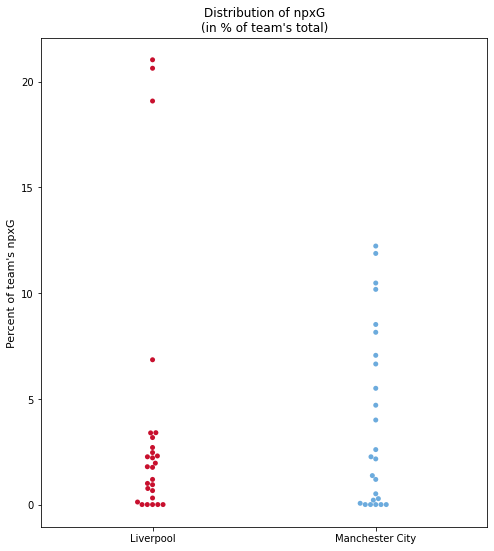

In [48]:
fig, ax = plt.subplots(figsize=(8,9))
palette = {"Liverpool" : "#C8102E", "Manchester City" : "#6CABDD"}
sns.swarmplot(x = "squad", y = "npxg_percentage", data = npxG_distribution, palette = palette)
plt.title("Distribution of npxG\n(in % of team's total)")
ax.set_xlabel('')
ax.set_ylabel("Percent of team's npxG", fontsize = 11)

We can see how radically different both teams distribute their shots, with City's npxG contribution much more spread out than Liverpool's, whose focus clearly lies on their front three. In fact, if we look at the npxG distriubutrion for the entire league, the uniqueness of both teams becomes even more apparent. 

/opt/anaconda3/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 16.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/opt/anaconda3/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 16.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/opt/anaconda3/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 20.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/opt/anaconda3/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 10.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/opt/anaconda3/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 10.3% of the points

[Text(0, -5.0, '−5'),
 Text(0, 0.0, '0'),
 Text(0, 5.0, '5'),
 Text(0, 10.0, '10'),
 Text(0, 15.0, '15'),
 Text(0, 20.0, '20'),
 Text(0, 25.0, '25'),
 Text(0, 30.0, '30')]

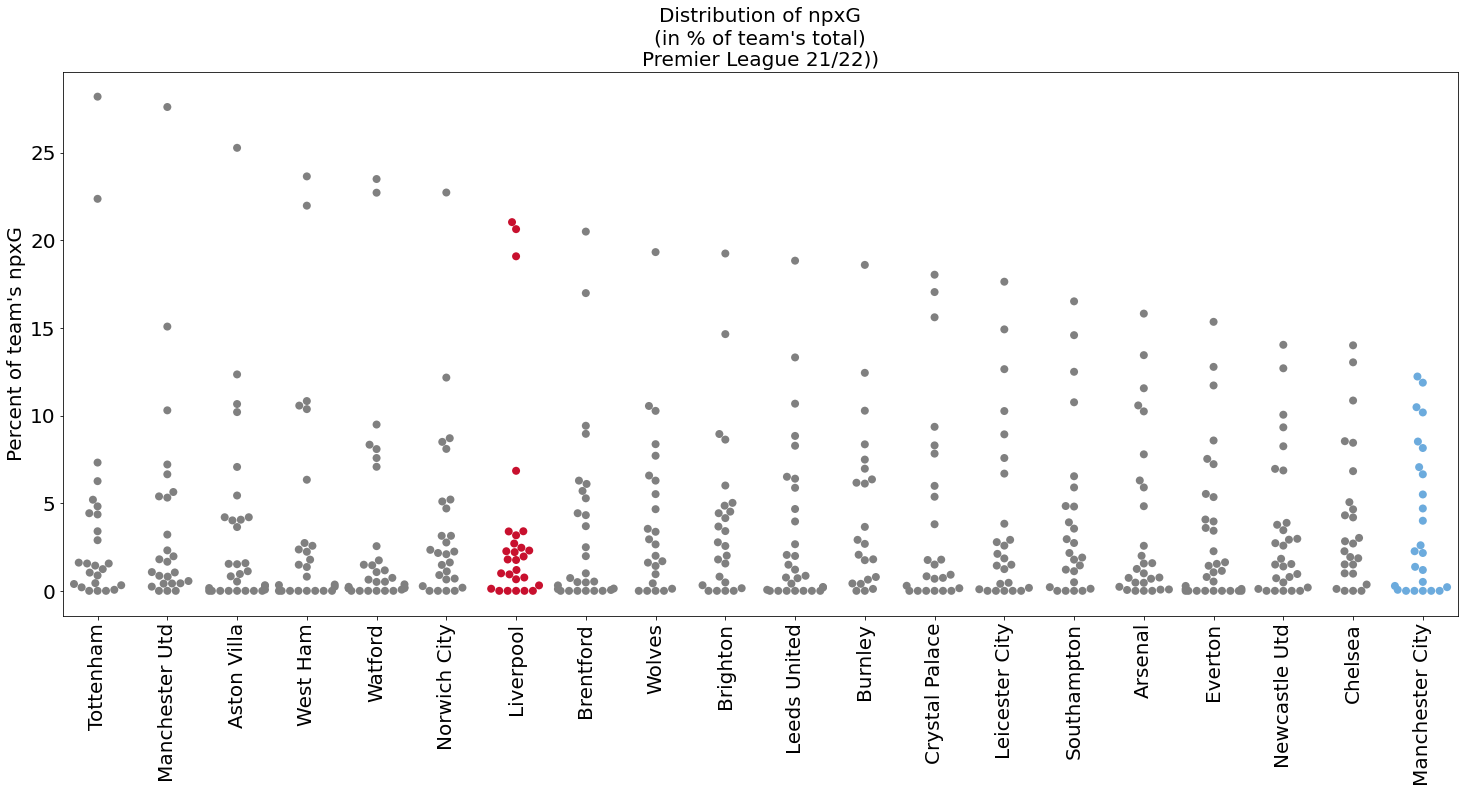

In [49]:
#converting the data into a data frame

league_distribution_command = '''
SELECT 
    squad,
    player_name,
    position,
    total_npxg, 
    ROUND(100 * total_npxg/SUM(total_npxg) OVER(PARTITION BY squad), 2) AS npxg_percentage
FROM standard_stats_players_total
ORDER BY npxg_percentage DESC;

'''
league_distribution = pd.read_sql(league_distribution_command, engine)


#specyfying a color palette with team colors to easily distinguish the two teams discussed


league_palette = {"Arsenal" : "gray", 
           "Aston Villa" : "gray",
           "Brentford" : "gray",
           "Brighton" : "gray",
           "Burnley" : "gray",
           "Chelsea" : "gray",
           "Crystal Palace" : "gray",
           "Everton" : "gray",
           "Leeds United" : "gray",
           "Leicester City" : "gray",
           "Liverpool" : "#C8102E", 
           "Manchester City" : "#6CABDD",
           "Manchester Utd" : "gray",
           "Newcastle Utd" : "gray",
           "Norwich City" : "gray",
           "Southampton" : "gray",
           "Tottenham" : "gray",
           "Watford" : "gray",
           "West Ham" : "gray",
           "Wolves" : "gray"
          }

#plotting the distribution of npxG for all teams in the league

fig, ax = plt.subplots(figsize=(25,10))
sns.swarmplot(x = "squad", y = "npxg_percentage", data = league_distribution,
               size = 8, palette = league_palette)

ax.set_title("Distribution of npxG\n(in % of team's total)\nPremier League 21/22))", fontsize = 20)
ax.set_xlabel("")
ax.set_ylabel("Percent of team's npxG", fontsize = 20)
ax.set_xticklabels(ax.get_xticklabels(), fontsize = 20, rotation = 90)
fig.canvas.draw()
ax.set_yticklabels(ax.get_yticklabels(), fontsize = 20)



We can see that City lacks a player who is mainly responsible for getting shots. It is in quite stark contrast to the rest of the league as most teams depend on one or two players to be the ones getting a large portion of their chances. We usually see a considerable distance between those players and the rest of the team. In the case of Man City, though, there exists no focal point, no player that is clearly tasked with being the shot-getter, although we do not observe as big a difference between the top players and the rest of the team. 


Liverpool, meanwhile, is pretty much the opposite: its chances are concentrated among three players, with very little from the rest of the team. What is also worth noting is that, while there are quite a few teams with two primary shoot-takers, the only team other than Liverpool that manages to have three is Crystal Palace, and even then, they do not account for as big a slice of chances as Liverpool's front three. 


Let's now look at City's chance creation.

In [50]:
%%sql

SELECT
    player_name,
    position,
    total_xa, 
     ROUND(100 * total_xa/SUM(total_xa) OVER(PARTITION BY squad), 2) AS xa_percentage
FROM standard_stats_players_total
WHERE squad = 'Manchester City'
ORDER BY total_xa DESC;

 * postgresql://localhost/premier_league_stats
25 rows affected.


player_name,position,total_xa,xa_percentage
Kevin De Bruyne,MF,5.472,12.38
Jack Grealish,FW,4.991,11.29
Phil Foden,FW,4.654,10.53
Bernardo Silva,MFFW,4.539,10.27
İlkay Gündoğan,MF,3.9,8.82
Gabriel Jesus,FW,3.427,7.75
Raheem Sterling,FW,3.306,7.48
João Cancelo,DF,3.228,7.30
Riyad Mahrez,FW,3.105,7.02
Rúben Dias,DF,2.133,4.82


Again, we can see a wider distribution than in Liverpool's case. The midfielders are also much more involved in creating chances, with three of them in the top 5 creators. Also notable is the asymmetric role of the starting fullbacks - João Cancelo contributing much more in attack than Kyle Walker.

To better see the contrast between the Liverpool's and Manchester City's midfields, let's look again at one of the previous graphs and highlight the midfield players in both teams.

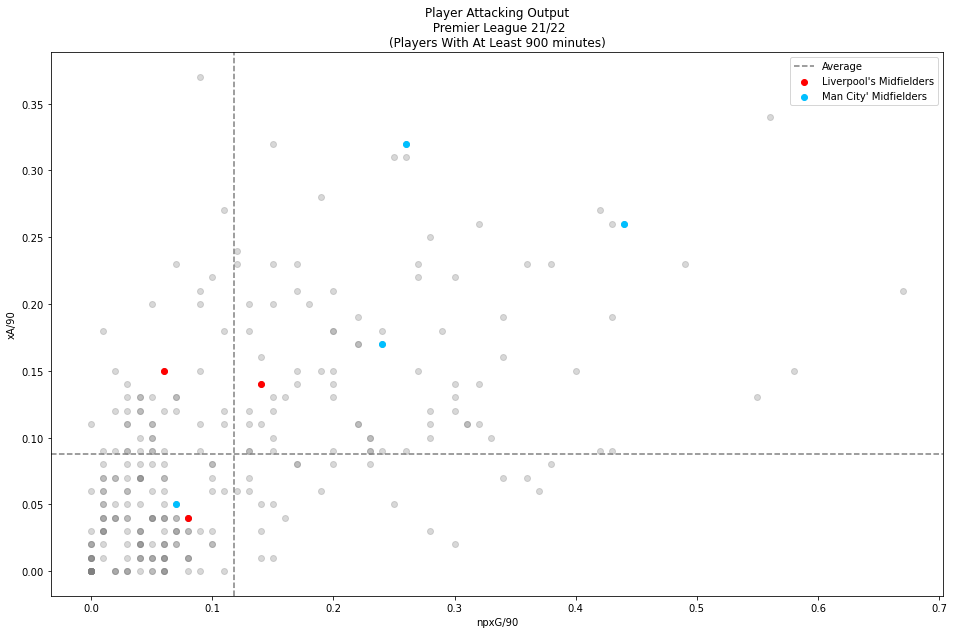

In [51]:
fig, ax = plt.subplots(1,1, figsize = (16,10))

ax.scatter(player_attack_contribution.npxG, player_attack_contribution.xA, alpha = 0.3, c = 'gray')


ax.set_title('Player Attacking Output\n Premier League 21/22\n(Players With At Least 900 minutes)')
ax.set_xlabel('npxG/90')
ax.set_ylabel('xA/90')

#marking the averages

ax.axvline(player_attack_contribution.npxG.mean(), c = 'gray', ls = '--', label = "Average")
ax.axhline(player_attack_contribution.xA.mean(), c = 'gray', ls = '--')


#creating a table with only defenders and plotting it on the graph

liv_mid_attack_contribution = player_attack_contribution[(player_attack_contribution.position.str.contains('MF')==True)
                                                        & (player_attack_contribution.squad == 'Liverpool')]

ax.scatter(liv_mid_attack_contribution.npxG, liv_mid_attack_contribution.xA, 
            c = 'red', label = "Liverpool's Midfielders")


city_mid_attack_contribution = player_attack_contribution[(player_attack_contribution.position.str.contains('MF')==True)
                                                        & (player_attack_contribution.squad == 'Manchester City')]

ax.scatter(city_mid_attack_contribution.npxG, city_mid_attack_contribution.xA,
           c = 'deepskyblue', label = "Man City' Midfielders")

ax.legend(fontsize = 10)


We can clearly see that City's midfielders contribute much more in attack, especially on the shot-getting side.  We can also clearly see that both teams designate one of the midfielders as much less attacking. 

CONCLUSION

We have managed to learn quite a lot about how Liverpool and Manchester City attack. What is the most striking is that, althought both teams are extremely successful in attack, they approach it in quite different ways. 

We found that Liverpool and City distribute their chance in radically different ways. The former have clear designated goalscorers, who are responsible for the majority of the team's chance. City, on the other hand, have the most uniformly distributed chances in the entire league, with many players chipping in and without a clear primary goalscorer.

Additionally, the way both teams use players in different positions is also vastly different. It is most evident in the way that midfielders function in both systems: Liverpool's rarely contributing in attack, while being one of City's main attackers. The opposite is true of the fullbacks - Liverpool's Trent Alexander-Arnold and Andrew Robertson are two of the team's main chance creators, with the former amassing the highest xA/90 in the league. City's Kyle Walker and Joao Cancelo are more reserved, with especially the former being barely present when it comes to attack.

This analysis shows that using fairly simple metric such as xG and xA can be fairly informative in evaluating how football teams attack and can increase our understanding they might differ in their approach.